In [87]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from matplotlib import pyplot as plt
import seaborn as sn
import numpy as np
from sklearn import metrics

In [88]:
#The labelled portion of our dataset has labels 0, 1 for the two levels of empathy (weak, strong)

data = pd.read_csv('empathy_annotate.csv')#put data in Drive root folder or change path
len(data)

1505

In [89]:
data = data.drop(["Annotator2","Annotator3","Annotator1"], axis=1)
data = data.dropna()
data.head()

,Response,Score
1,Hi {Bob}. I am a robot specialising in creativ...,0.0
2,Hi {Bob}! How are you feeling today? I'm Creat...,1.0
3,"Hello {Bob}, are you having a good day, how do...",0.0
4,"Hi {Bob}, this is CreativeBot. How are you today?",0.0
5,"Hello {Bob}, my name is CreativeBot and I'm he...",1.0


In [90]:
data.groupby('Score').size()

Score
0.0    741
1.0    673
dtype: int64

In [91]:
data["Score"].replace({0:"weak",1:"strong"},inplace=True)
data.head()

,Response,Score
1,Hi {Bob}. I am a robot specialising in creativ...,weak
2,Hi {Bob}! How are you feeling today? I'm Creat...,strong
3,"Hello {Bob}, are you having a good day, how do...",weak
4,"Hi {Bob}, this is CreativeBot. How are you today?",weak
5,"Hello {Bob}, my name is CreativeBot and I'm he...",strong


In [92]:
#generate the text files for your train, val, and test datasets 

train_path = "empathy_dataset/my_train.txt"
test_path = "empathy_dataset/my_test.txt"
val_path = "empathy_dataset/my_val.txt"


from sklearn.model_selection import train_test_split
import numpy as np

# Creating training and validation sets using an 85-15 split
input_train, input_val, target_train, target_val = train_test_split(data.Response.to_numpy(), 
                                                                    data.Score.to_numpy(), 
                                                                    test_size=0.15)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 67:33
seed = 22
input_val, input_test, target_val, target_test = train_test_split(input_val, target_val, test_size=0.33, random_state=seed)


## create a dataframe for each dataset
train_dataset = pd.DataFrame(data={"text": input_train, "class": target_train})
val_dataset = pd.DataFrame(data={"text": input_val, "class": target_val})
test_dataset = pd.DataFrame(data={"text": input_test, "class": target_test})
final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

#and write them to file
train_dataset.to_csv(train_path, sep=";",header=False, index=False)
val_dataset.to_csv(val_path, sep=";",header=False, index=False)
test_dataset.to_csv(test_path, sep=";",header=False, index=False)

In [93]:
#we will use the concatenated train and validation test to fit our logistic regression function
train_val = pd.concat([train_dataset, val_dataset])

In [94]:
train_val.head()

,text,class
0,Why not try some of my suggestions of activiti...,weak
1,Everybody struggles to think of a creative dom...,strong
2,Can you think of a creative task you wish to t...,strong
3,Feel free to relax the muscles around your mou...,weak
4,Would you like to do another round? I don't me...,weak


c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Train+val: Target distribution')

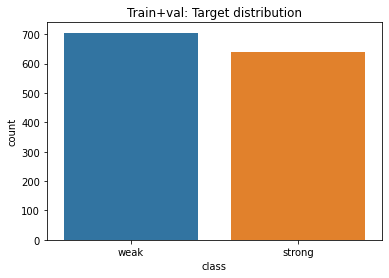

In [95]:
#visualise label distribution
sn.countplot(train_val['class'])
plt.title('Train+val: Target distribution')

In [96]:
text_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=150000)

In [97]:
X_train_text = text_transformer.fit_transform(train_val['text'])
X_test_text = text_transformer.transform(test_dataset['text'])

In [98]:
print(X_train_text.shape, 
      X_test_text.shape)

(1343, 6992) (71, 6992)


In [99]:
logit = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4)

In [100]:
logit.fit(X_train_text, train_val['class'])

LogisticRegression(C=50.0, multi_class='multinomial', n_jobs=4, random_state=17)

In [101]:
test_preds = logit.predict(X_test_text)

In [102]:
y_pred = pd.DataFrame(test_preds, columns=['class'])
y_pred.head()

,class
0,strong
1,weak
2,weak
3,weak
4,weak


In [103]:
#check accuracy, we get ~60% on train+val set
outputs = y_pred['class'].to_numpy().tolist()
targets = test_dataset['class'].to_numpy().tolist()

metrics.accuracy_score(targets, outputs).round(4)

0.6338

In [107]:
#check all metrics
print(metrics.classification_report(targets, outputs, digits=4))

              precision    recall  f1-score   support

      strong     0.6216    0.6571    0.6389        35
        weak     0.6471    0.6111    0.6286        36

    accuracy                         0.6338        71
   macro avg     0.6343    0.6341    0.6337        71
weighted avg     0.6345    0.6338    0.6337        71



In [105]:
cm = metrics.confusion_matrix(targets, outputs)

<AxesSubplot:>

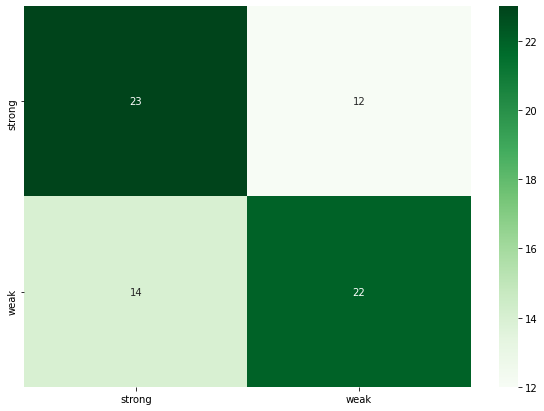

In [106]:
df_cm = pd.DataFrame(cm, index = ["strong", "weak"], columns = ["strong", "weak"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g')